# TP 1 – RNN : Génération de musique ABC

## Installation des dépendances

In [1]:
!pip install torch datasets tensorboard tqdm


## 1. Chargement du dataset


In [2]:
from datasets import load_dataset

dataset = load_dataset("sander-wood/irishman")
train_data = dataset["train"].select(range(2000))   # subset pour le TP
val_data = dataset["validation"].select(range(200))

print("Train size:", len(train_data))
print("Validation size:", len(val_data))
print("Exemple de chanson :", train_data[0]["abc notation"][:200], "...")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.json:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/214122 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2162 [00:00<?, ? examples/s]

Train size: 2000
Validation size: 200
Exemple de chanson : X:1
L:1/8
M:4/4
K:Emin
|: E2 EF E2 EF | DEFG AFDF | E2 EF E2 B2 |1 efe^d e2 e2 :|2 efe^d e3 B |: e2 ef g2 fe | 
 defg afdf |1 e2 ef g2 fe | efe^d e3 B :|2 g2 bg f2 af | efe^d e2 e2 || ...


## 2. Prétraitement
### 2.1 Caractères uniques

In [3]:
all_text = "".join(song["abc notation"] for song in train_data)
vocab = sorted(set(all_text))
print("Nombre de caractères uniques:", len(vocab))

Nombre de caractères uniques: 91


### 2.2 Mapping caractère ↔ index


In [4]:
char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = {i: c for c, i in char2idx.items()}
vocab_size = len(vocab)
PAD_CHAR = " " if " " in char2idx else vocab[0]
pad_idx = char2idx[PAD_CHAR]

### 2.3 Vectorisation avec gestion des caractères inconnus


In [5]:
def vectorize_string(s):
    return [char2idx.get(c, pad_idx) for c in s]  # si caractère inconnu -> padding


### 2.4 Padding et tronquage


In [6]:
max_len = 300  # tronquer pour le TP

def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        seq += [pad_idx] * (max_len - len(seq))
    return seq[:max_len]

## 3. Dataset PyTorch


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class MusicDataset(Dataset):
    def __init__(self, data):
        self.data = [
            pad_sequence(vectorize_string(song["abc notation"]), max_len)
            for song in data
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data[idx], dtype=torch.long)
        x = seq[:-1]   # entrée
        y = seq[1:]    # cible décalée
        return x, y

train_dataset = MusicDataset(train_data)
val_dataset = MusicDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Vérification
x, y = next(iter(train_loader))
print("Batch X:", x.shape, "Y:", y.shape)

Batch X: torch.Size([16, 299]) Y: torch.Size([16, 299])


## 4. Modèle LSTM léger


In [8]:
import torch.nn as nn

class MusicRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

## 5. Entraînement avec Early Stopping


In [9]:
from tqdm import tqdm
import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter

def train_model(model, train_loader, val_loader, max_epochs=10, lr=5e-3, patience=3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    writer = SummaryWriter()
    best_val_loss = float("inf")
    wait = 0
    actual_epochs = 0
    best_epoch = 0

    train_loss_list = []
    val_loss_list = []

    for epoch in range(max_epochs):
        actual_epochs += 1

        # --- Training ---
        model.train()
        train_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Train]"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out.reshape(-1, vocab_size), y.reshape(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)

        # --- Validation ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out.reshape(-1, vocab_size), y.reshape(-1))
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_list.append(val_loss)

        # Logging
        writer.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
        print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            torch.save(model.state_dict(), "best_model.pth")
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}!")
                break

    epochs_left = max_epochs - actual_epochs

    # --- Training Summary ---
    print("\n=== Training Summary ===")
    print(f"Total epochs performed       : {actual_epochs}")
    print(f"Epochs remaining (not used)  : {epochs_left}")
    print(f"Best model saved at epoch    : {best_epoch}")
    print("\nTrain Loss per epoch :")
    print(train_loss_list)
    print("\nValidation Loss per epoch :")
    print(val_loss_list)

    return train_loss_list, val_loss_list, best_epoch

# --- Initialisation et entraînement ---
model = MusicRNN(vocab_size=vocab_size)
train_loss_list, val_loss_list, best_epoch = train_model(model, train_loader, val_loader, max_epochs=10, lr=5e-3, patience=3)


Epoch 1/10 [Train]: 100%|██████████| 125/125 [00:02<00:00, 50.81it/s]


Epoch 1/10 | Train Loss: 1.6419 | Val Loss: 1.2663


Epoch 2/10 [Train]: 100%|██████████| 125/125 [00:01<00:00, 82.64it/s]


Epoch 2/10 | Train Loss: 1.1729 | Val Loss: 1.1306


Epoch 3/10 [Train]: 100%|██████████| 125/125 [00:01<00:00, 82.93it/s]


Epoch 3/10 | Train Loss: 1.0724 | Val Loss: 1.0671


Epoch 4/10 [Train]: 100%|██████████| 125/125 [00:01<00:00, 82.94it/s]


Epoch 4/10 | Train Loss: 1.0206 | Val Loss: 1.0380


Epoch 5/10 [Train]: 100%|██████████| 125/125 [00:01<00:00, 82.14it/s]


Epoch 5/10 | Train Loss: 0.9840 | Val Loss: 1.0140


Epoch 6/10 [Train]: 100%|██████████| 125/125 [00:01<00:00, 74.55it/s]


Epoch 6/10 | Train Loss: 0.9553 | Val Loss: 0.9998


Epoch 7/10 [Train]: 100%|██████████| 125/125 [00:01<00:00, 77.46it/s]


Epoch 7/10 | Train Loss: 0.9367 | Val Loss: 0.9947


Epoch 8/10 [Train]: 100%|██████████| 125/125 [00:01<00:00, 82.10it/s]


Epoch 8/10 | Train Loss: 0.9167 | Val Loss: 0.9835


Epoch 9/10 [Train]: 100%|██████████| 125/125 [00:01<00:00, 82.90it/s]


Epoch 9/10 | Train Loss: 0.8997 | Val Loss: 0.9816


Epoch 10/10 [Train]: 100%|██████████| 125/125 [00:01<00:00, 82.35it/s]

Epoch 10/10 | Train Loss: 0.8842 | Val Loss: 0.9896

=== Training Summary ===
Total epochs performed       : 10
Epochs remaining (not used)  : 0
Best model saved at epoch    : 9

Train Loss per epoch :
[1.6418866443634033, 1.17289484167099, 1.072389015197754, 1.0206220908164978, 0.9839601035118103, 0.9553245902061462, 0.9366971387863159, 0.9167306060791016, 0.8997322421073913, 0.8842237973213196]

Validation Loss per epoch :
[1.2662896651488085, 1.1306479985897357, 1.0671457189780016, 1.0380093134366548, 1.0139914155006409, 0.9997696051230798, 0.9947126186811007, 0.9835407550518329, 0.9816221044613764, 0.9895991545457107]


## 6. Génération de musique


In [10]:
def generate_music(model, start_seq, length=200):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    seq = torch.tensor([char2idx.get(c, pad_idx) for c in start_seq], dtype=torch.long).unsqueeze(0).to(device)
    generated = list(start_seq)

    for _ in range(length):
        with torch.no_grad():
            out = model(seq)
            probs = F.softmax(out[0, -1], dim=0)
            next_idx = torch.multinomial(probs, 1).item()
        generated.append(idx2char[next_idx])
        seq = torch.cat([seq, torch.tensor([[next_idx]]).to(device)], dim=1)

    return "".join(generated)

# Charger le meilleur modèle et générer une musique
model.load_state_dict(torch.load("best_model.pth"))
print(generate_music(model, "X:1\nT:Generated\nM:4/4\nK:D\n", 200))

X:1
T:Generated
M:4/4
K:D
 (3DEF | GABc dcBA | GFDD FGFG | A2 FD ECCG | AFFE DA,FG |1,3 dBGB, FADF | DFEF G2 :| 
 efef | (3edc (3BGE D2 DB, | D2 GD G2 GF | G3 A BAGF | EDAD ADDD D3 F | 
 A3 A FDAF AFDF | ABcd edBA defe | dcAg 


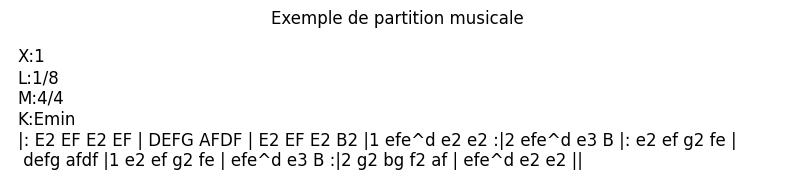

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

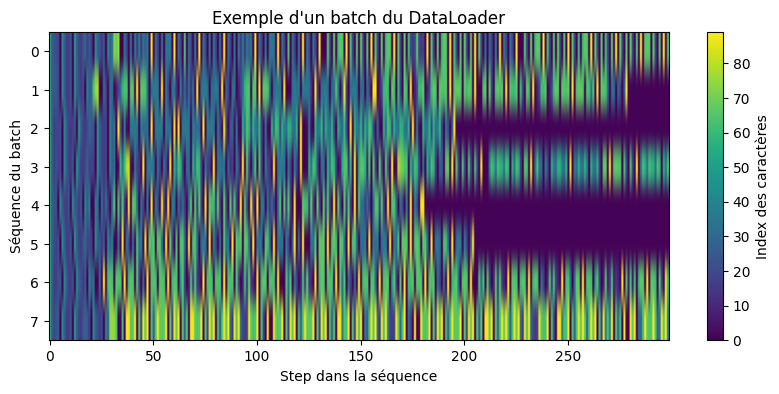

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

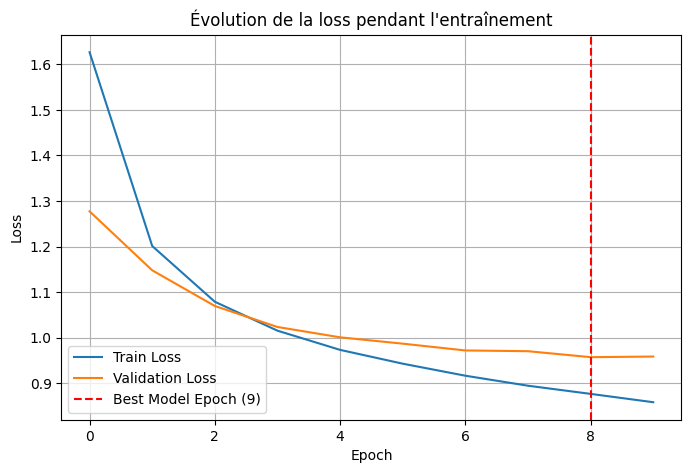

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

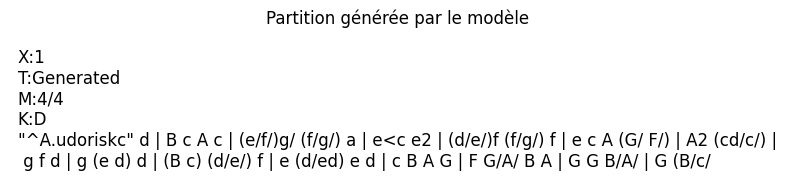

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import matplotlib.pyplot as plt
from google.colab import files

# --- 1. Exemple de partition du dataset ---
example_song = train_data[0]["abc notation"]

plt.figure(figsize=(10,2))
plt.text(0.01, 0.5, example_song, fontsize=12, va='center', wrap=True)
plt.axis('off')
plt.title("Exemple de partition musicale")
plt.savefig("exemple_partition.png", bbox_inches='tight')
plt.show()
files.download("exemple_partition.png")  # <-- Téléchargement

# --- 2. Exemple d'un batch du DataLoader ---
x_batch, y_batch = next(iter(train_loader))
plt.figure(figsize=(10,4))
plt.imshow(x_batch[:8].cpu(), cmap='viridis', aspect='auto')
plt.colorbar(label="Index des caractères")
plt.xlabel("Step dans la séquence")
plt.ylabel("Séquence du batch")
plt.title("Exemple d'un batch du DataLoader")
plt.savefig("dataloader.png", bbox_inches='tight')
plt.show()
files.download("dataloader.png")  # <-- Téléchargement

# --- 3. Évolution de la loss pendant l'entraînement ---
plt.figure(figsize=(8,5))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.axvline(best_epoch-1, color='r', linestyle='--', label=f'Best Model Epoch ({best_epoch})')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Évolution de la loss pendant l'entraînement")
plt.legend()
plt.grid(True)
plt.savefig("training_loss.png", bbox_inches='tight')
plt.show()
files.download("training_loss.png")  # <-- Téléchargement

# --- 4. Partition générée par le modèle ---
generated_seq = generate_music(model, "X:1\nT:Generated\nM:4/4\nK:D\n", length=200)

plt.figure(figsize=(10,2))
plt.text(0.01, 0.5, generated_seq, fontsize=12, va='center', wrap=True)
plt.axis('off')
plt.title("Partition générée par le modèle")
plt.savefig("generated_music.png", bbox_inches='tight')
plt.show()
files.download("generated_music.png")  # <-- Téléchargement
